# Compare optimizer

In [ ]:
import qiskit
import numpy as np, matplotlib.pyplot as plt
import sys
sys.path.insert(1, '../')
import qtm.base, qtm.constant, qtm.fubini_study

In [2]:
theta = np.pi / 3  # np.random.uniform(0, np.pi)
phi = np.pi / 4 # np.random.uniform(0, 2*np.pi)
lambdaz = 0

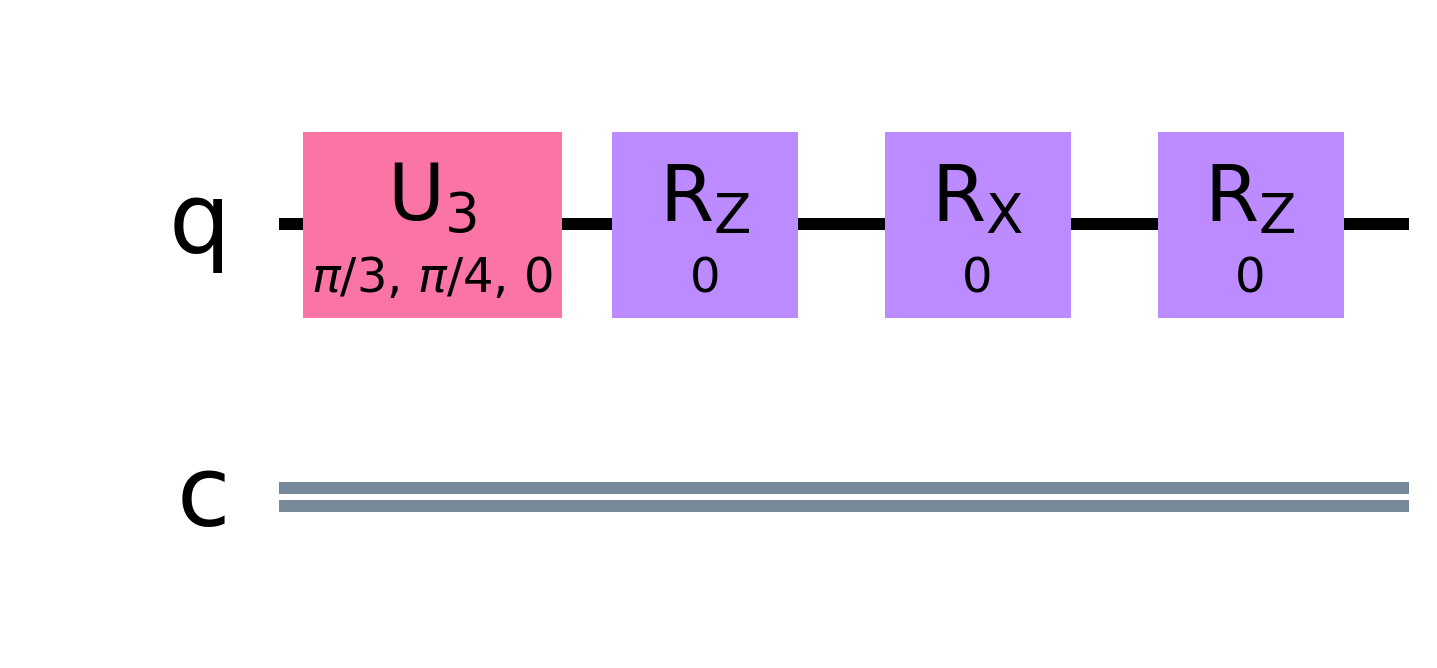

In [5]:
thetas = np.zeros((3,))
qc = qiskit.QuantumCircuit(1, 1)
qc.u3(theta, phi, lambdaz, 0)
qc = qtm.ansatz.u_onequbit(qc, thetas)
qc.draw('mpl', filename = 'u3.eps', scale = 6)

In [6]:
thetas = np.zeros((3,))
loss_values = []
qc = qiskit.QuantumCircuit(1, 1)
qc.u3(theta, phi, lambdaz, 0)

thetass_sgd, loss_values_sgd = qtm.base.fit(
    qc, num_steps = 100, thetas = thetas, 
    create_circuit_func = qtm.ansatz.u_onequbit, 
    grad_func = qtm.base.grad_loss,
    loss_func = qtm.loss.loss_fubini_study,
    optimizer = qtm.optimizer.sgd,
    is_return_all_thetas = True,
    verbose = 1,
    wire = 0
)


Step: 100%|██████████| 100/100 [00:33<00:00,  2.97it/s]


In [7]:
thetas = np.zeros((3,))
loss_values = []
qc = qiskit.QuantumCircuit(1, 1)
qc.u3(theta, phi, lambdaz, 0)

thetas_adam, loss_values_adam = qtm.base.fit(
    qc, num_steps = 100, thetas = thetas, 
    create_circuit_func = qtm.ansatz.u_onequbit, 
    grad_func = qtm.base.grad_loss,
    loss_func = qtm.loss.loss_fubini_study,
    optimizer = qtm.optimizer.adam,
    verbose = 1,
    wire = 0
)



Step: 100%|██████████| 100/100 [00:25<00:00,  3.87it/s]


In [8]:
thetas = np.zeros((3,))
loss_values_qng = []
qc = qiskit.QuantumCircuit(1, 1)
qc.u3(theta, phi, lambdaz, 0)
thetas_qng = []

for i in range(0, 100):
    G = qtm.fubini_study.calculate_u3z_state(qc.copy(), thetas)
    grad_loss = qtm.base.grad_loss(
        qc, 
        qtm.ansatz.u_onequbit,
        thetas, wire = 0)
    thetas = np.real(thetas - qtm.constant.learning_rate *
                        (np.linalg.pinv(G) @ grad_loss)) 
    thetas_qng.append(thetas.copy())
    qc_copy = qtm.ansatz.u_onequbit(qc.copy(), thetas, wire = 0)  
    loss = qtm.loss.loss_fubini_study(qtm.base.measure(qc_copy, list(range(qc_copy.num_qubits))))
    loss_values_qng.append(loss)

In [9]:
thetas = np.zeros((3,))
loss_values_qng_adam = []
qc = qiskit.QuantumCircuit(1, 1)
qc.u3(theta, phi, lambdaz, 0)

for i in range(0, 100):
    G = qtm.fubini_study.calculate_u3z_state(qc.copy(), thetas)
    grad_loss = qtm.base.grad_loss(
        qc, 
        qtm.ansatz.u_onequbit,
        thetas, wire = 0)
    grad1 = np.real(np.linalg.inv(G) @ grad_loss)
    if i == 0:
        m, v = list(np.zeros(thetas.shape[0])), list(np.zeros(thetas.shape[0]))
    thetas = qtm.optimizer.adam(thetas, m, v, i, grad1)  
    qc_copy = qtm.ansatz.u_onequbit(qc.copy(), thetas, wire = 0)  
    loss = qtm.loss.loss_fubini_study(qtm.base.measure(qc_copy, list(range(qc_copy.num_qubits))))
    loss_values_qng_adam.append(loss)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


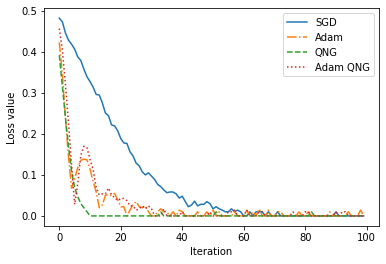

In [12]:
plt.plot(loss_values_sgd, label='SGD', linestyle = '-')
plt.plot(loss_values_adam, label='Adam', linestyle = '-.')
plt.plot(loss_values_qng, label='QNG', linestyle = '--')
plt.plot(loss_values_qng_adam, label='Adam QNG', linestyle = ':')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss value")
plt.savefig('compare_optimizer.eps', format='eps', dpi=600)
plt.show() 

### Visualize how good of QNG

In [57]:
def state_coords(statevector):
    alpha = statevector[0]
    alpha_r = alpha.real
    alpha_i = alpha.imag

    beta = statevector[1]
    beta_r = beta.real
    beta_i = beta.imag

    theta = np.arccos((alpha_r**2)-(alpha_i**2))
    
    if theta==0:
        phi=0
    else:
        phi = np.arccos((1/np.sin(theta/2))*((alpha_r*beta_r) + (alpha_i*beta_i)))
        
    if ((alpha_r*beta_i) - (alpha_i*beta_r)) < 0:
        phi += np.pi
    
    # theta = np.arccos(statevector[0])
    # phi = (np.log(statevector[1]/np.sin(theta))/1j)
    x = (np.sin(theta)*np.cos(phi))
    y = (np.sin(theta)*np.sin(phi))
    z = (np.cos(theta))
    return [x, y, z]

In [69]:
psi = state_coords(qiskit.quantum_info.Statevector.from_instruction(qc).data)
psi_hat_qng = []
psi_hat_sgd = []
for thetas in thetas_qng:
    
    temp = qiskit.quantum_info.Statevector(qtm.base.get_u_hat(
        thetas = thetas, 
        create_circuit_func = qtm.ansatz.u_onequbit, 
        num_qubits = qc.num_qubits, 
        wire = 0)
    )
    psi_hat_qng.append(state_coords(temp.data))

for thetas in thetass_sgd:
    
    temp = qiskit.quantum_info.Statevector(qtm.base.get_u_hat(
        thetas = thetas, 
        create_circuit_func = qtm.ansatz.u_onequbit, 
        num_qubits = qc.num_qubits, 
        wire = 0)
    )
    psi_hat_sgd.append(state_coords(temp.data))

In [65]:
path = "../../experiments/compare_optimizer/u3initstate_zbasis_1qubit/"
np.savetxt(path + "/loss_values_sgd.csv", loss_values_sgd, delimiter=",")
np.savetxt(path + "/loss_values_adam.csv", loss_values_sgd, delimiter=",")
np.savetxt(path + "/loss_values_qng.csv", loss_values_qng, delimiter=",")
np.savetxt(path + "/loss_values_qng_adam.csv", loss_values_qng_adam, delimiter=",")

np.savetxt(path + "/thetass_qng.csv", thetas_qng, delimiter=",")
np.savetxt(path + "/thetass_sgd.csv", thetass_sgd, delimiter=",")

np.savetxt(path + "/psi_hat_sgd.csv", psi_hat_sgd, delimiter=",")
np.savetxt(path + "/psi_hat_qng.csv", psi_hat_qng, delimiter=",")

In [ ]:
import kaleidoscope
from matplotlib.colors import LinearSegmentedColormap, rgb2hex
cm = LinearSegmentedColormap.from_list('graypurple', ["#999999", "#999999"])
cm2 = LinearSegmentedColormap.from_list('grayblue', ["#000000", "#000000"])
vectors_color1 = [rgb2hex(cm(kk)) for kk in np.linspace(-1,1, 40)]
vectors_color2 = [rgb2hex(cm2(kk)) for kk in np.linspace(-1,1, 10)]
red = ['#FF0000']
colors = ([*vectors_color1, *vectors_color2, *red])
kaleidoscope.bloch_sphere(
    points = psi_hat_sgd[0:40] + psi_hat_qng[0:10] + [psi_hat_qng[15]],
    points_color = colors,
    figsize = (1000, 1000)
)

# kaleidoscope.bloch_sphere(qiskit.quantum_info.Statevector.from_instruction(qc))
# kaleidoscope.bloch_sphere(points = [[theta, phi, np.sqrt(1 - theta**2 - phi**2)]])

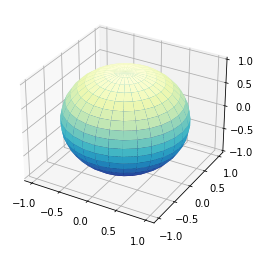

In [66]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
r = 0.05
u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)
ax.plot_surface(x, y, z, cmap=plt.cm.YlGnBu_r)
plt.show()